## 1. Definizione imports

In [1]:
#roba generica
import numpy as np
from pathlib import Path
from PIL import Image

#gestione dataframe
import pandas as pd

#per grafici
import cv2 as cv
import matplotlib.pyplot as plt

#pytorch
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

#usati da albumentations, contengono modelli e trasformazioni popolari
import torchvision.models as models
from torchvision.transforms.functional import to_grayscale
from torchvision.utils import make_grid

#modifica immagini (colorazione, blur, ecc ecc)
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

#metriche di bontà
from sklearn.metrics import accuracy_score, roc_auc_score

#barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

#reti preaddestrate di efficientnet
from efficientnet_pytorch import EfficientNet

#dataset personalizzato usato dal dataloader (applica delle trasformazioni alle immagini)

from TachiNNUtils import ConcreteDataset, ConcreteModel
from TachiNNUtils import c_filepath, c_cracks

## 2. Definizione Variabili

### Definizione variabili generiche

In [2]:
#VARIABILE DI TEST PER ESEGUIRE IL TAGLIO AL DATASET (IL TRAINING DIVENTA MOLTO LUNGO ALTRIMENTI, ED è GIUSTO COSì)
#SERVE SOLO X TESTARE IL FUNZIONAMENTO DI TUTTE LE FUNZIONI
CUT_TRAINING = True

#----- VARIABILI PER I PERCORSI DEL DATASET -----
#path per la classe negativa (senza crepe)
#ds_normal = Path('../../Dataset/Default/surface-crack-detection/Negative')
ds_normal = Path('C:/Users/gianl/Downloads/Concrete Crack Images for Classification/Negative')

#path per la classe positiva (con le crepe)
#ds_cracks = Path('../../Dataset/Default/surface-crack-detection/Positive')
ds_cracks = Path('C:/Users/gianl/Downloads/Concrete Crack Images for Classification/Positive')
#------------------------------------------------

#----- VARIABILI PER IL DATAFRAME -----
#Dimensione del training set: valori accettabili da 0 a 1 (in genere si prende l'80/85%)
training_set_size = 0.85
#seed per il random
rseed = 567
#c_filepath = "filepath"#TachiDataset.c_filepath
#c_cracks = "cracks"#TachiDataset.c_cracks
#--------------------------------------

#PRINT VALORE VARIABILI
print("Path Dataset Normal: " + str(ds_normal))
print("Path Dataset Cracks: " + str(ds_cracks))
print("Dimensione Training set: " + str(training_set_size * 100) + "%")

Path Dataset Normal: C:\Users\gianl\Downloads\Concrete Crack Images for Classification\Negative
Path Dataset Cracks: C:\Users\gianl\Downloads\Concrete Crack Images for Classification\Positive
Dimensione Training set: 85.0%


### Definizione variabili della Rete

In [24]:
#BATCH SIZE
batch_size = 64
BS = batch_size

#EPOCHE DI TRAINING (!!> 0)
training_epoques = 5
TE = training_epoques

#LEARNING RATE
learning_rate= 1e-1
LR = learning_rate

#WEIGHT DECAY
weight_decay= 0.02
WD = weight_decay

###################################################
#LOSS FUNCTION
loss_fn = F.binary_cross_entropy_with_logits
###################################################

#PRINT VALORE VARIABILI RETE
print("Batch size: " + str(BS))
print("Learning Rate: " + str(LR))
print("Weight Decay: " + str(WD))
print("Selected Loss Function: " + str(loss_fn).split("at")[0][1:])

Batch size: 64
Learning Rate: 0.1
Weight Decay: 0.02
Selected Loss Function: function binary_cross_entropy_with_logits 


## 3. Preparazione Data

### Caricamento dei dataset

In [4]:
train_data = [(o,0) for o in ds_normal.iterdir()]
train_data_cracks = [(o,1) for o in ds_cracks.iterdir()]
train_data.extend(train_data_cracks)

train_data = pd.DataFrame(train_data, columns=[c_filepath, c_cracks])

### Generazione Training set e Validation set

In [22]:
np.random.seed(rseed)
msk = np.random.rand(len(train_data)) < training_set_size

train_df = train_data[msk].reset_index()
val_df = train_data[~msk].reset_index()

############################################################################
#TAGLIO IL DATASET SE INDICATO ALL'INIZIO (RAGIONI DI TEST DEL CODICE)
if CUT_TRAINING == True:
    train_df = train_df.drop(train_df.index[5000:30000])
    val_df = val_df.drop(val_df.index[100:5000])
############################################################################

#PRINT VALORE DIMENSIONI TRAINING SET E VALIDATION SET
print("Elements Training set: " + str(len(train_df)))
print("Elements Validation set: " + str(len(val_df)))

Elements Training set: 8944
Elements Validation set: 1156


## 4. Visualizzazione Immagini dei due set di dati

In [6]:
#Numero di immagini da mostrare
plots = 4
#dimensioni delle immagini
#altezza
plots_height = 20
#larghezza
plots_width = 20

### Immagini senza crepe

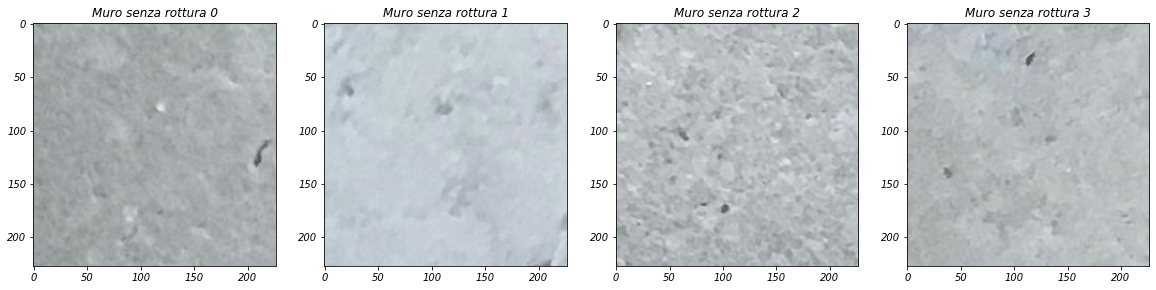

In [7]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
for i in range(plots):
    a[i].imshow(cv.imread(str(train_data.iloc[i][c_filepath])))
    a[i].set_title("Muro senza rottura " + str(i))

### Immagini con le crepe

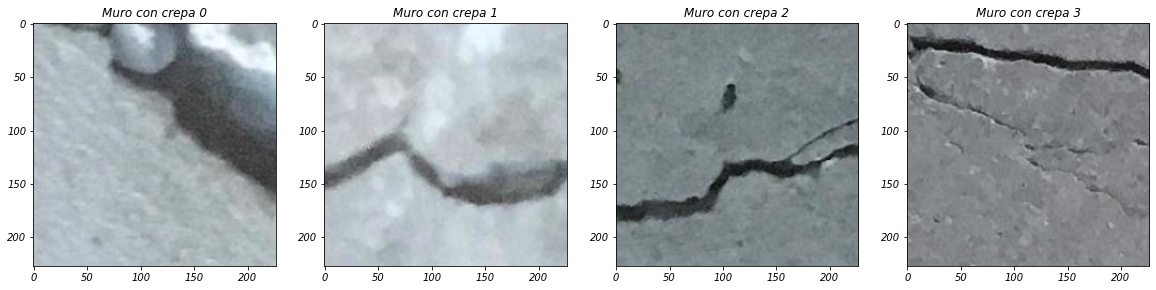

In [8]:
#creo plot ed imposto le dimensioni
fig,a =  plt.subplots(1, plots)
fig.set_figheight(plots_height)
fig.set_figwidth(plots_width)
#carico le immagini
for i in range(-plots, 0):
    a[i].imshow(cv.imread(str(train_data.iloc[i][c_filepath])))
    a[i].set_title("Muro con crepa " + str(plots + i))

## 5. Dataset Transformation

In [9]:
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
train_tfms = A.Compose(
    [
        A.Cutout(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        ToTensor(normalize=imagenet_stats)
    ])
    
test_tfms = A.Compose(
    [
        ToTensor(normalize=imagenet_stats)
    ])

### Trasformo i dataset in modo che seguano la classe ConcreteDataset

In [10]:
train_ds = ConcreteDataset(train_df, transforms=train_tfms)
val_ds = ConcreteDataset(val_df, transforms=test_tfms, is_test=True)
len(train_ds), len(val_ds)

(300, 156)

In [11]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=64, 
                    num_workers=2, pin_memory=True)
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 3, 227, 227]), torch.Size([64, 1]))

## 6. Training della rete

### Metodi per il training

In [12]:
def get_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def get_model(model_name='efficientnet-b0', lr=1e-5, wd=0.01, freeze_backbone=False, opt_fn=torch.optim.AdamW, device=None):
    device = device if device else get_device()
    model = ConcreteModel(eff_name=model_name)
    if freeze_backbone:
        for parameter in model.backbone.parameters():
            parameter.requires_grad = False
    opt = opt_fn(model.parameters(),lr=lr,weight_decay=wd)
    model = model.to(device)
    return model, opt

def training_step(xb,yb,model,loss_fn,opt,device,scheduler):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    opt.zero_grad()
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()
    scheduler.step()
    return loss.item()
    
def validation_step(xb,yb,model,loss_fn,device):
    xb,yb = xb.to(device), yb.to(device)
    out = model(xb)
    loss = loss_fn(out,yb)
    out = torch.relu(out)#torch.sigmoid(out)
    return loss.item(),out

def get_data(train_df,valid_df,train_tfms,test_tfms,bs):
    train_ds = ConcreteDataset(df=train_df,transforms=train_tfms)
    valid_ds = ConcreteDataset(df=valid_df,transforms=test_tfms)
    train_dl = DataLoader(dataset=train_ds,batch_size=bs,shuffle=True,num_workers=4)
    valid_dl = DataLoader(dataset=valid_ds,batch_size=bs*2,shuffle=False,num_workers=4)
    return train_dl,valid_dl

In [13]:
def fit(epochs, model, train_dl, valid_dl, opt, loss_fn, device=None):
    
    device = device if device else get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    val_rocs = []
    tloss = []
    vloss = []
    
    #Creating progress bar
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','val_roc'],table=True)

    for epoch in mb:    
        trn_loss,val_loss = 0.0,0.0
        val_preds = np.zeros((len(valid_dl.dataset),1))
        val_targs = np.zeros((len(valid_dl.dataset),1))
        
        #Training
        model.train()
        
        #For every batch 
        for xb,yb in progress_bar(train_dl,parent=mb):
            trn_loss += training_step(xb, yb, model, loss_fn,opt,device,scheduler) 
        trn_loss /= mb.child.total
        tloss.append(trn_loss)

        #Validation
        model.eval()
        with torch.no_grad():
            for i,(xb,yb) in enumerate(progress_bar(valid_dl,parent=mb)):
                loss,out = validation_step(xb,yb,model,loss_fn,device)
                val_loss += loss
                bs = xb.shape[0]
                val_preds[i*bs:i*bs+bs] = out.cpu().numpy()
                val_targs[i*bs:i*bs+bs] = yb.cpu().numpy()

        val_loss /= mb.child.total
        vloss.append(val_loss)
        val_roc = roc_auc_score(val_targs.reshape(-1),val_preds.reshape(-1))
        val_rocs.append(val_roc)

        mb.write([epoch,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{val_roc:.6f}'],table=True)
    return model,val_rocs, tloss, vloss

### Caricamento pesi dalla rete pre-allenata

In [14]:
train_dl,valid_dl = get_data(train_df, val_df, train_tfms, test_tfms, BS)
model, opt = get_model(model_name='efficientnet-b0', freeze_backbone=True, lr=LR, wd=WD)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\gianl/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0


### Training effettivo della rete

In [15]:
model,val_rocs, train_loss, valid_loss = fit(TE, model, train_dl, valid_dl, opt, loss_fn)

epoch,train_loss,valid_loss,val_roc
0,5.362604,78.068432,0.142500
1,0.602210,9.826104,0.142500
2,0.182506,62.898867,0.145000
3,0.749145,70.260387,0.150000
4,0.354341,68.062840,0.165000


### Plot risultati del Training

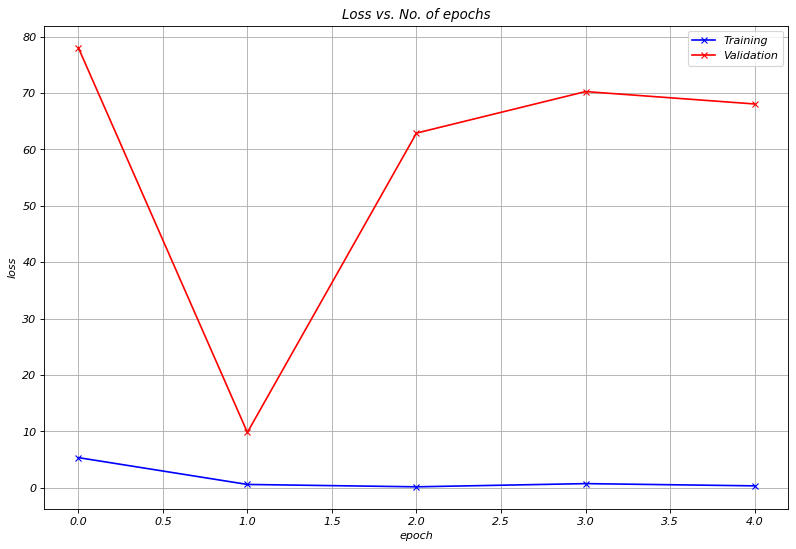

In [16]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');
plt.grid()